# Chapter 4 - Preprocessing and Pipelines

## Creating dummy variables

In [1]:
import pandas as pd

In [2]:
music_df = pd.read_csv('./datasets/music_clean_orig.csv', index_col=[0])

In [3]:
music_df

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,genre
0,41.0,0.644000,0.823,236533.0,0.814,0.687000,0.1170,-5.611,0.1770,102.619000,0.6490,Jazz
1,62.0,0.085500,0.686,154373.0,0.670,0.000000,0.1200,-7.626,0.2250,173.915000,0.6360,Rap
2,42.0,0.239000,0.669,217778.0,0.736,0.000169,0.5980,-3.223,0.0602,145.061000,0.4940,Electronic
3,64.0,0.012500,0.522,245960.0,0.923,0.017000,0.0854,-4.560,0.0539,120.406497,0.5950,Rock
4,60.0,0.121000,0.780,229400.0,0.467,0.000134,0.3140,-6.645,0.2530,96.056000,0.3120,Rap
...,...,...,...,...,...,...,...,...,...,...,...,...
995,65.0,0.000983,0.531,216067.0,0.855,0.000000,0.0716,-4.950,0.0352,124.578000,0.4240,Rock
996,38.0,0.033200,0.608,218624.0,0.938,0.000000,0.3100,-2.681,0.2870,134.198000,0.4360,Electronic
997,56.0,0.005790,0.939,144453.0,0.373,0.000000,0.2740,-7.779,0.2270,119.953000,0.0602,Rap
998,64.0,0.250000,0.546,178147.0,0.631,0.000000,0.1230,-5.757,0.0283,129.556000,0.5690,Rock


We need to build binary features for each song's genre.

In [4]:
# Convert categorical columns to series of dummy variables
# drop_first: produce k-1 dummy variables from original k
music_dummies = pd.get_dummies(music_df, drop_first=True)

In [5]:
music_dummies.shape

(1000, 20)

9 new columns were added, as 10 values were in the 'genre' column. The 'genre' column was also dropped automatically.

Now, we will build a ridge regression model to predict song popularity.

In [6]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, KFold
import numpy as np

In [7]:
X = music_dummies.drop(['popularity'], axis=1)
y = music_dummies['popularity']

In [8]:
ridge = Ridge(alpha=0.2)

In [9]:
kf = KFold(n_splits=5)

In [10]:
scores = cross_val_score(ridge, X, y, cv=kf, scoring="neg_mean_squared_error")

In [11]:
rmse = np.sqrt(-scores)
print("Average RMSE: {}".format(np.mean(rmse)))
print("Standard Deviation of the target array: {}".format(np.std(y)))

Average RMSE: 8.276818395409242
Standard Deviation of the target array: 14.02156909907019


Here we see the average RMSE of 8.27 is lower than the standard deviation of the target variable (song popularity), suggesting the model is reasonably accurate.

## Missing values

In [12]:
music_df = pd.read_csv('./datasets/music_clean_missing.csv', index_col=[0])

In [13]:
print(music_df.isna().sum().sort_values())

genre                 8
popularity           31
loudness             44
liveness             46
tempo                46
speechiness          59
duration_ms          91
instrumentalness     91
danceability        143
valence             143
acousticness        200
energy              200
dtype: int64


In [14]:
# Remove values where less than 5% are missing
music_df = music_df.dropna(subset=["genre", "popularity", "loudness", "liveness", "tempo"])

In [15]:
# Convert genre to a binary feature
music_df["genre"] = np.where(music_df["genre"] == "Rock", 1, 0)

In [16]:
print(music_df.isna().sum().sort_values())
print("Shape of the `music_df`: {}".format(music_df.shape))

popularity            0
liveness              0
loudness              0
tempo                 0
genre                 0
duration_ms          29
instrumentalness     29
speechiness          53
danceability        127
valence             127
acousticness        178
energy              178
dtype: int64
Shape of the `music_df`: (892, 12)


We have gone from 1000 observations to 892 after removing column data with less than 5% missing.

## Pipelines

In [17]:
# Not sure what DataCamp is doing to the data between exercises :O
music_df = pd.read_csv('./datasets/music_clean_pipeline.csv', index_col=[0])

In [18]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [19]:
imputer = SimpleImputer() # defaults to mean imputation

In [20]:
knn = KNeighborsClassifier(n_neighbors=3)

In [21]:
steps = [("imputer", imputer), 
         ("knn", knn)]

In [22]:
X = music_df.drop(['genre'], axis=1).values
y = music_df['genre'].values

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer()),
                ('knn', KNeighborsClassifier(n_neighbors=3))])

In [25]:
y_pred = pipeline.predict(X_test)

In [26]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[79  9]
 [ 4 82]]
              precision    recall  f1-score   support

           0       0.95      0.90      0.92        88
           1       0.90      0.95      0.93        86

    accuracy                           0.93       174
   macro avg       0.93      0.93      0.93       174
weighted avg       0.93      0.93      0.93       174



/Users/harrybaines/Documents/Coding/DataCamp-ML-Scientist-Track/datacampenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


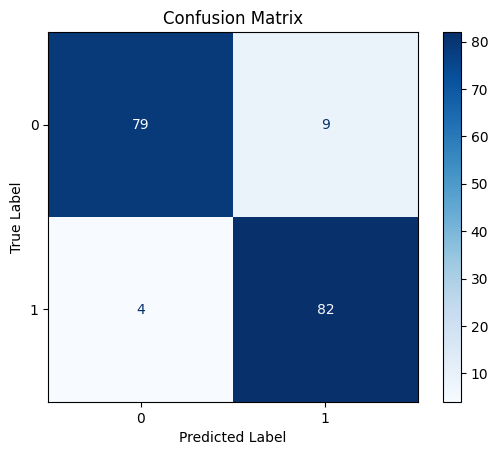

In [27]:
color = 'black'
matrix = plot_confusion_matrix(pipeline, X_test, y_test, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

## Centering and scaling

Here we will build a pipeline to preprocess the music dataset features and build a lasso regression model to predict a song's loudness.

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

In [29]:
music_df = pd.read_csv('./datasets/music_clean_center_scaling.csv', index_col=[0])

In [30]:
X = music_df.drop(['loudness'], axis=1).values
y = music_df['loudness'].values

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [32]:
steps = [("scaler", StandardScaler()),
         ("lasso", Lasso(alpha=0.5))]

In [33]:
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('lasso', Lasso(alpha=0.5))])

In [34]:
print(pipeline.score(X_test, y_test))

0.6294826383621106


We get an R-squared of 0.629, compared to an R-squared of 0.393 without scaling!

Next, we will build a peipline to scale features in `music_df` and use grid search CV using a logistic regression model with different C values, to predict the target 'genre'.

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [36]:
music_df = pd.read_csv('./datasets/music_clean_center_scaling.csv', index_col=[0])

In [37]:
steps = [("scaler", StandardScaler()),
         ("logreg", LogisticRegression())]

In [38]:
X = music_df.drop(['genre'], axis=1).values
y = music_df['genre'].values

In [39]:
pipeline = Pipeline(steps)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=21)

In [41]:
parameters = {"logreg__C": np.linspace(0.001, 1.0, 20)}

In [42]:
cv = GridSearchCV(pipeline, param_grid=parameters)
cv.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'logreg__C': array([0.001     , 0.05357895, 0.10615789, 0.15873684, 0.21131579,
       0.26389474, 0.31647368, 0.36905263, 0.42163158, 0.47421053,
       0.52678947, 0.57936842, 0.63194737, 0.68452632, 0.73710526,
       0.78968421, 0.84226316, 0.89484211, 0.94742105, 1.        ])})

In [43]:
print(cv.best_score_, "\n", cv.best_params_)

0.8425 
 {'logreg__C': 0.1061578947368421}


We get a final model with an accuracy of 0.8425 with a C value of approximately 0.1.

Finally, we will build three regression models to predict a song's 'energy' levels.

In [44]:
from sklearn.linear_model import LinearRegression

In [45]:
music_df = pd.read_csv('./datasets/music_clean_missing.csv', index_col=[0])

In [46]:
music_df = music_df.dropna(subset=["genre", "popularity", "loudness", "liveness", "tempo"])

In [47]:
music_dummies = pd.get_dummies(music_df, drop_first=True)

In [48]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=0.1),
    "Lasso": Lasso(alpha=0.1)
}

In [49]:
X = music_dummies.drop(['energy'], axis=1).values
y = music_dummies['energy'].values

In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=21)

In [51]:
imputer = SimpleImputer()

In [52]:
X_train = imputer.fit_transform(X_train)
y_train = imputer.fit_transform(y_train.reshape(-1,1))
X_test = imputer.fit_transform(X_test)
y_test = imputer.fit_transform(y_test.reshape(-1,1))

In [53]:
results = []

# Loop through the models' values
for model in models.values():
    kf = KFold(n_splits=6, random_state=42, shuffle=True)
  
    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf)
  
    # Append the results
    results.append(cv_scores)

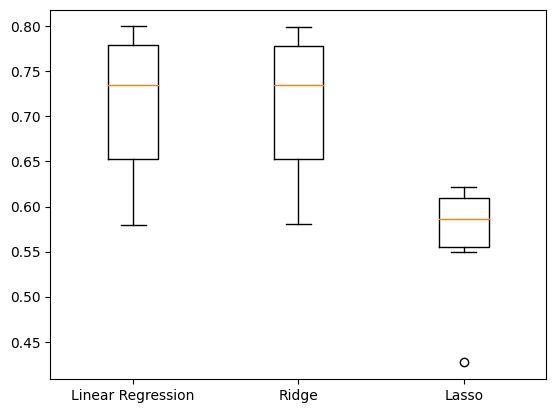

In [54]:
# Create a box plot of the results
plt.boxplot(results, labels=models.keys())
plt.show()

We see lasso regression is not a good model for this problem, while linear regression and ridge regression perform fairly equally.

Next, we will check predictive performance on the test set to see if either linear or ridge regression are better. We use RMSE as the metric.

In [55]:
from sklearn.metrics import mean_squared_error

In [56]:
scaler = StandardScaler()

In [57]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [58]:
for name, model in models.items():
  
    # Fit the model to the training data
    model.fit(X_train_scaled, y_train)
  
    # Make predictions on the test set
    y_pred = model.predict(X_test_scaled)
  
    # Calculate the test_rmse
    test_rmse = mean_squared_error(y_test, y_pred, squared=False)
    print("{} Test Set RMSE: {}".format(name, test_rmse))

Linear Regression Test Set RMSE: 0.12267024610658882
Ridge Test Set RMSE: 0.12267397733287912
Lasso Test Set RMSE: 0.17292833360218704


The linear regression model only slightly edges the best performance.

Next, let's build a model to classify whether a song is popular or not.

In [59]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [60]:
music_dummies['popularity'] = np.where(
    music_dummies['popularity'] > music_dummies['popularity'].median(),
    1,
    0
)

In [61]:
X = music_dummies.drop(['popularity'], axis=1).values
y = music_dummies['popularity'].values

In [62]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=21)

In [63]:
imputer = SimpleImputer()

In [64]:
X_train = imputer.fit_transform(X_train)
y_train = imputer.fit_transform(y_train.reshape(-1, 1)).ravel()
X_test = imputer.fit_transform(X_test)
y_test = imputer.fit_transform(y_test.reshape(-1, 1)).ravel()

In [65]:
scaler = StandardScaler()

In [66]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [67]:
X_train_scaled.shape

(713, 19)

In [68]:
models = {
  "Logistic Regression": LogisticRegression(),
  "KNN": KNeighborsClassifier(),
  "Decision Tree Classifier": DecisionTreeClassifier()
}

In [69]:
results = []

# Loop through the models' values
for model in models.values():
  
    # Instantiate a KFold object
    kf = KFold(n_splits=6, random_state=12, shuffle=True)
  
    # Perform cross-validation
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kf)
    results.append(cv_results)

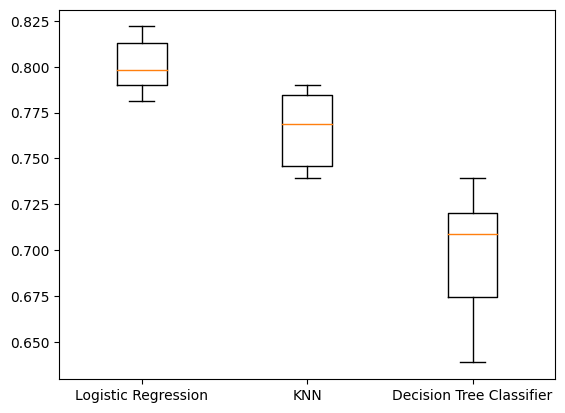

In [70]:
plt.boxplot(results, labels=models.keys())
plt.show()

Logistic regression seems to be the best model based on the cross-validation results.

Finally, we will build a pipeline to perform all preprocessing operations and perform hyperparameter tuning of a logistic regression model. We will find the best parameters and accuracy when predicting song genre.

In [71]:
music_df = pd.read_csv('./datasets/music_clean_center_scaling.csv', index_col=[0])

In [72]:
X = music_df.drop(['genre'], axis=1).values
y = music_df['genre'].values

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=21)

In [74]:
steps = [("imp_mean", SimpleImputer()), 
         ("scaler", StandardScaler()), 
         ("logreg", LogisticRegression())]

In [75]:
pipeline = Pipeline(steps)
params = {"logreg__solver": ["newton-cg", "saga", "lbfgs"],
         "logreg__C": np.linspace(0.001, 1.0, 10)}

In [76]:
tuning = GridSearchCV(pipeline, param_grid=params)
tuning.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('imp_mean', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'logreg__C': array([0.001, 0.112, 0.223, 0.334, 0.445, 0.556, 0.667, 0.778, 0.889,
       1.   ]),
                         'logreg__solver': ['newton-cg', 'saga', 'lbfgs']})

In [77]:
y_pred = tuning.predict(X_test)

In [78]:
print("Tuned Logistic Regression Parameters: {}, Accuracy: {}".format(tuning.best_params_, tuning.score(X_test, y_test)))

Tuned Logistic Regression Parameters: {'logreg__C': 0.112, 'logreg__solver': 'newton-cg'}, Accuracy: 0.825


We get a final model which is 82% accuracy in predicting song genres.